In [5]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import os
from huggingface_hub import login
import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
import json
import einops
from sklearn.exceptions import ConvergenceWarning
import warnings
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}


In [2]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers
NHEADS = model.config.n_head

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

# Getting Functions
Gets dataframe, how we do in intervention, and identifies important MLPs in circuit

In [3]:

def get_df():
    ndf1 = pd.read_pickle('data/all_neuron_fits/results.pkl')['neurondf']
    return ndf1

def get_intervention_results(helix_type):
    assert helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab'], f"helix_type must be one of ['a_b', 'ab', 'a_b_ab'], got {helix_type}"
    save_dir = "data_addition/ab_mlps"
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
    helix_act = np.zeros((NLAYERS,))
    helix_path = np.zeros((NLAYERS,))
    full_act = np.zeros((NLAYERS,))
    full_path = np.zeros((NLAYERS,))
    for layer in range(NLAYERS):
        helix_act[layer] = results[layer][helix_type]['act_logdiff']
        helix_path[layer] = results[layer][helix_type]['path_logdiff']
        full_act[layer] = results[layer]['full']['act_logdiff']
        full_path[layer] = results[layer]['full']['path_logdiff']
    return helix_act, helix_path, full_act, full_path

def get_topk_mlps(k):
    _,_, full_act, _ = get_intervention_results('helix_a_b')
    layers = list(range(NLAYERS))
    # Sort layers by their full_act values in descending order and get top k
    sorted_layers = [x for _,x in sorted(zip(full_act, layers), reverse=True)]
    return sorted_layers[:k]

def read_topk_mlp_patches():
    # Read results from file
    save_dir = "data_addition/ab_mlps"
    results = np.load(f"{save_dir}/topk_mlp_act_patch_results_{MODEL_NAME}.npy")
    return results

def get_mlps_threshold(pct):
    results = read_topk_mlp_patches()
    max_logdiff = max(results)
    threshold = max_logdiff * pct
    # Find first k that exceeds threshold
    k = next(i for i, v in enumerate(results) if v >= threshold)
    return k, sorted(get_topk_mlps(k))



# Analyzes neuron fits
Functions to do analysis on the cosine fits for the neurons and calculates/returns the fraction of fit magnitude from various helices

In [4]:
def get_terms(idx):
    data = np.load(f'data/neuron_fits/neuron_{idx}.npz', allow_pickle=True)
    model_data = data['model']
    periods = [2,5,10,100]
    
    # Get amplitudes using list comprehensions
    amags = [model_data.item()['amplitudes'][i*3].item() for i in range(len(periods))]
    bmags = [model_data.item()['amplitudes'][i*3 + 1].item() for i in range(len(periods))]
    abmags = [model_data.item()['amplitudes'][i*3 + 2].item() for i in range(len(periods))]
    
    return np.array(amags), np.array(bmags), np.array(abmags)

def get_ab_mag(idx):
    amags, bmags, abmags = get_terms(idx)
    amag = np.sum(amags**2)
    bmag = np.sum(bmags**2)
    abmag = np.sum(abmags**2)
    total = amag+bmag+abmag
    frac = abmag /total
    return frac.item()

def run_all_abmags():
    ndf = get_df()
    fracs = []
    bar = tqdm(range(len(ndf)))
    for idx in bar:
        frac = get_ab_mag(idx)
        fracs.append(frac)
        bar.set_postfix(layer=ndf.iloc[idx]['layer'], neuron_idx=ndf.iloc[idx]['neuron_idx'], frac=frac)
    ndf['ab_frac'] = fracs
    ndf.to_pickle('data_addition/neuron_fits/neuron_ab_fractions.pkl')
    return ndf

def load_ab_fractions(frac = 1):
    ndf = pd.read_pickle('data_addition/neuron_fits/neuron_ab_fractions.pkl')
    n = int(len(ndf) * frac)
    return ndf.nlargest(n, 'logit_difference')
#load_ab_fractions()

# Plotting ab fraction
We want to see how much of the neurons in various mlps can be explained by a+b helix

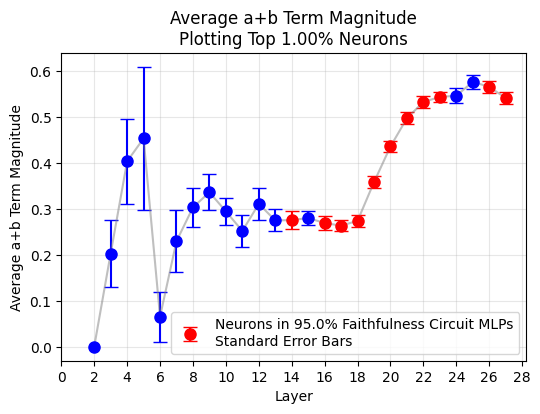

In [5]:
def plot_ab_fractions(base_perc = 0.01):
    ndf = load_ab_fractions(base_perc*100)
    plt.figure(figsize=(6, 4))
    
    # Group by layer and calculate mean and std of ab_fracs
    layer_stats = (
    ndf.groupby('layer')['ab_frac']
    .agg(mean='mean', std='std', count='count')
    .reset_index())

    layer_stats['sem'] = layer_stats['std'] / layer_stats['count']**0.5

    thresh = 0.95
    
    _, circuit_mlps = get_mlps_threshold(thresh)
    
    # Split data into circuit and non-circuit points
    circuit_mask = layer_stats['layer'].isin(circuit_mlps)
    circuit_data = layer_stats[circuit_mask]
    non_circuit_data = layer_stats[~circuit_mask]
    
    # Plot non-circuit error bars and points in blue
    plt.errorbar(non_circuit_data['layer'], non_circuit_data['mean'],
                yerr=non_circuit_data['sem'],
                fmt='o',
                capsize=5, 
                markersize=8,
                color='b')
    
    # Plot circuit error bars and points in red  
    plt.errorbar(circuit_data['layer'], circuit_data['mean'],
                yerr=circuit_data['sem'],
                fmt='o',
                capsize=5,
                markersize=8, 
                color='r',
                label=f'Neurons in {100*thresh}% Faithfulness Circuit MLPs\nStandard Error Bars')
    
    # Plot single connecting line through all points
    all_data = pd.concat([non_circuit_data, circuit_data]).sort_values('layer')
    plt.plot(all_data['layer'], all_data['mean'], '-', color='gray', alpha=0.5)
    
    plt.xlabel('Layer')
    plt.ylabel('Average a+b Term Magnitude')
    plt.title(f'Average a+b Term Magnitude\nPlotting Top {base_perc*100:.2f}% Neurons')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Set x-ticks every 2 layers
    plt.xticks(range(0, int(all_data['layer'].max()) + 2, 2))
    
    # Save the figure
    plt.savefig('figs_addition/neuron_graphs/ab_fraction_by_layer.png',
                bbox_inches='tight',
                dpi=300)
    plt.show()
    plt.close()
plot_ab_fractions(base_perc = 0.01)

# Fraction of Neurons in Circuit MLPs

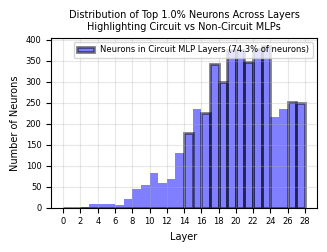

In [15]:
def plot_neuron_hist(base_frac = 0.01):
    ndf = load_ab_fractions(base_frac*100)
    thresh = 0.95
    _, circuit_mlps = get_mlps_threshold(thresh)
    # Calculate percentage of neurons in circuit MLPs
    total_neurons = len(ndf)
    circuit_neurons = len(ndf[ndf['layer'].isin(circuit_mlps)])
    circuit_pct = 100 * circuit_neurons / total_neurons
    
    # Create histogram
    plt.figure(figsize=(3.25, 2.5))
    
    # Plot non-circuit neurons in blue
    plt.hist(ndf[~ndf['layer'].isin(circuit_mlps)]['layer'], 
             bins=range(0, int(ndf['layer'].max()) + 2),
             color='blue',
             alpha=0.5)
    
    # Plot circuit neurons with blue fill and black edge
    plt.hist(ndf[ndf['layer'].isin(circuit_mlps)]['layer'],
             bins=range(0, int(ndf['layer'].max()) + 2), 
             color='blue',
             alpha=0.5,
             edgecolor='black',
             linewidth=2,
             label=f'Neurons in Circuit MLP Layers ({circuit_pct:.1f}% of neurons)')
    
    plt.xlabel('Layer')
    plt.ylabel('Number of Neurons')
    plt.title(f'Distribution of Top {base_frac*100}% Neurons Across Layers\nHighlighting Circuit vs Non-Circuit MLPs')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Set x-ticks every 2 layers
    plt.xticks(range(0, int(ndf['layer'].max()) + 2, 2))
    
    # Save the figure
    plt.tight_layout()
    plt.savefig('figs_addition/neuron_graphs/neuron_circuit_distribution.png',
                bbox_inches='tight',
                dpi=300)
    plt.show()
    plt.close()

plot_neuron_hist(0.01)

# Plot number of path patching neurons required 

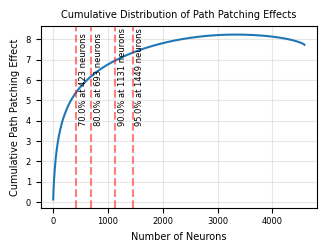

In [18]:
def load_path_patch():
    df = pd.read_csv('data_addition/neuron_path_patching.csv', index_col=False)
    return df
def get_path_patch_threshold(threshold=0.7):
    df = load_path_patch()
    df = df.sort_values('path_patch', ascending=False).reset_index(drop=True)
    total_effect = df['path_patch'].sum()
    target_value = total_effect * threshold
    neuron_idx = (df['path_patch'].cumsum() >= target_value).idxmax()
    return df.iloc[:neuron_idx+1]
    
def plot_path_patch_percentage():
    # Read and sort by path_patch
    df = load_path_patch()
    df = df.sort_values('path_patch', ascending=False).reset_index(drop=True)
    
    # Calculate total path patch effect
    total_effect = df['path_patch'].sum()
    
    # Calculate cumulative sum
    df['cumulative_sum'] = df['path_patch'].cumsum()
    
    # Create plot
    plt.figure(figsize=(3.25, 2.5))
    plt.plot(range(len(df)), df['cumulative_sum'])
    # Add vertical lines at percentage thresholds
    thresholds = [0.7, 0.8, 0.9, 0.95]
    for thresh in thresholds:
        target_value = total_effect * thresh
        neuron_idx = (df['cumulative_sum'] >= target_value).idxmax()
        plt.axvline(x=neuron_idx, color='red', linestyle='--', alpha=0.5)
        plt.text(neuron_idx+50, total_effect/2, f'{thresh*100}% at {neuron_idx} neurons', rotation=90)
    plt.xlabel('Number of Neurons')
    plt.ylabel('Cumulative Path Patching Effect')
    plt.title('Cumulative Distribution of Path Patching Effects')
    plt.grid(True, alpha=0.3)
    
    # Save figure
    plt.tight_layout()
    plt.savefig('figs_addition/neuron_graphs/neurons_path_patch_cumulative.png',
                bbox_inches='tight',
                dpi=300)
    plt.show()
    plt.close()

plot_path_patch_percentage()

# Plot distribution of path patch neurons compared to normal act patch neurons

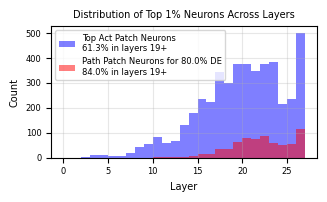

In [25]:
# Plot distribution of path patch neurons
def path_distribution(threshold = 0.8):
    top_pathdf = get_path_patch_threshold(threshold)
    ndf = load_ab_fractions()
    # Take top 654 entries of path patching data
    
    # Create histogram plot
    plt.figure(figsize=(3.25, 2))
    
    # Calculate percentage of all neurons in layer 19 and later
    all_late_neurons = len(ndf[ndf['layer'] >= 19])
    all_late_pct = (all_late_neurons / len(ndf)) * 100
    # Plot histogram of all neurons in blue
    plt.hist(ndf['layer'], bins=range(28), alpha=0.5, color='blue', 
             label=f'Top Act Patch Neurons\n{all_late_pct:.1f}% in layers 19+')
    # Calculate percentage of neurons in layer 19 and later
    late_neurons = len(top_pathdf[top_pathdf['layer'] >= 19])
    late_pct = (late_neurons / len(top_pathdf)) * 100
    
    # Plot histogram of top path patching neurons in red
    plt.hist(top_pathdf['layer'], bins=range(28), alpha=0.5, color='red', 
             label=f'Path Patch Neurons for {threshold*100}% DE\n{late_pct:.1f}% in layers 19+')
    plt.xlabel('Layer')
    plt.ylabel('Count')
    plt.title('Distribution of Top 1% Neurons Across Layers')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    plt.tight_layout()
    plt.savefig('figs_addition/neuron_graphs/neurons_path_patch_distribution.png',
                bbox_inches='tight', 
                dpi=300)
    plt.show()
    plt.close()

path_distribution()

# Plot the de/ie ratio as a function of layer

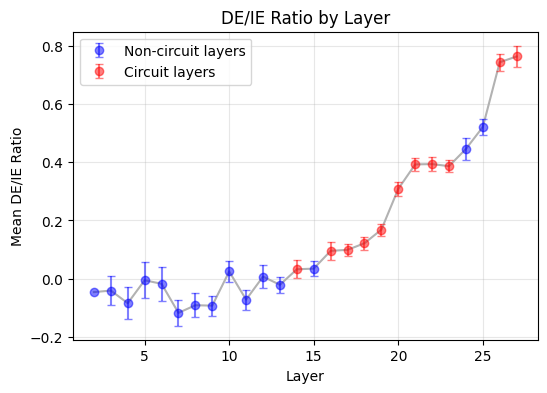

In [9]:
def plot_de_ie():
    df = load_path_patch()
    df['de_ie'] = df['path_patch']/df['logit_difference']
    
    # Calculate mean and standard error by layer
    layer_stats = df.groupby('layer')['de_ie'].agg(['mean', 'std', 'count']).reset_index()
    layer_stats['se'] = layer_stats['std'] / np.sqrt(layer_stats['count'])
    _, circuit_mlps = get_mlps_threshold(pct = 0.95)
    
    # Split into circuit and non-circuit layers
    circuit_stats = layer_stats[layer_stats['layer'].isin(circuit_mlps)]
    noncircuit_stats = layer_stats[~layer_stats['layer'].isin(circuit_mlps)]
    
    plt.figure(figsize=(6, 4))
    
    # Plot non-circuit layers with error bars
    plt.errorbar(noncircuit_stats['layer'], noncircuit_stats['mean'],
                yerr=noncircuit_stats['se'],
                fmt='o', capsize=3, color='blue', alpha=0.5,
                label='Non-circuit layers')
    
    # Plot circuit layers with error bars
    plt.errorbar(circuit_stats['layer'], circuit_stats['mean'],
                yerr=circuit_stats['se'],
                fmt='o', capsize=3, color='red', alpha=0.5,
                label='Circuit layers')
    
    # Plot line through all points
    plt.plot(layer_stats['layer'], layer_stats['mean'], 
            'k-', alpha=0.3, zorder=0)
    
    plt.xlabel('Layer')
    plt.ylabel('Mean DE/IE Ratio')
    plt.title('DE/IE Ratio by Layer')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.savefig('figs_addition/neuron_graphs/de_ie_by_layer.png',
                bbox_inches='tight',
                dpi=300)
    plt.show()
    plt.close()

plot_de_ie()

# See correlation between DE/IE ratio and reading from a+b helix

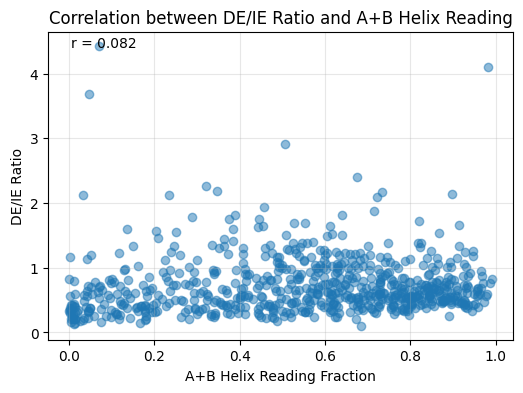

In [10]:
def correlation_deie_abhelix():
    pathdf = get_path_patch_threshold(0.8)
    pathdf['de_ie'] = pathdf['path_patch']/pathdf['logit_difference']
    ab_df = load_ab_fractions()
    
    # Merge dataframes on layer and neuron_idx
    df = pd.merge(pathdf, ab_df[['layer', 'neuron_idx', 'ab_frac']], 
                 on=['layer', 'neuron_idx'],
                 how='inner')
    
    # Create scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(df['ab_frac'], df['de_ie'], alpha=0.5)
    plt.ylabel('DE/IE Ratio')
    plt.xlabel('A+B Helix Reading Fraction')
    plt.title('Correlation between DE/IE Ratio and A+B Helix Reading')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    corr = df['de_ie'].corr(df['ab_frac'])
    plt.text(0.05, 0.95, f'r = {corr:.3f}', 
             transform=plt.gca().transAxes)
    
    plt.savefig('figs_addition/neuron_graphs/deie_abhelix_correlation.png',
                bbox_inches='tight',
                dpi=300)
    plt.show()
    plt.close()

correlation_deie_abhelix()

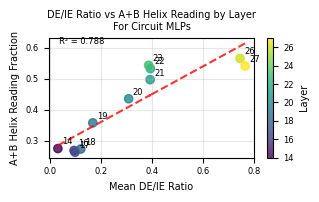

In [29]:
def correlation_deie_abhelix_layer():
    pathdf = load_path_patch()#get_path_patch_threshold(0.8)
    pathdf['de_ie'] = pathdf['path_patch']/pathdf['logit_difference']
    ab_df = load_ab_fractions()
    
    # Merge dataframes on layer and neuron_idx
    df = pd.merge(pathdf, ab_df[['layer', 'neuron_idx', 'ab_frac']], 
                 on=['layer', 'neuron_idx'],
                 how='inner')
    
    # Circuit MLP layers
    _, circuit_mlps = get_mlps_threshold(pct = 0.95)
    
    # Calculate means per layer, filtering for circuit MLPs only
    layer_means = df[df['layer'].isin(circuit_mlps)].groupby('layer').agg({
        'de_ie': 'mean',
        'ab_frac': 'mean'
    }).reset_index()
    
    # Create scatter plot
    plt.figure(figsize=(3.25, 2))
    
    # Calculate line of best fit
    x = layer_means['de_ie']
    y = layer_means['ab_frac']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    r_squared = np.corrcoef(x, y)[0,1]**2
    
    # Plot layer means with viridis colormap
    scatter = plt.scatter(x, y, alpha=0.8, 
                         c=layer_means['layer'], 
                         cmap='viridis')
    plt.colorbar(scatter, label='Layer')
    
    # Plot line of best fit
    plt.plot(x, p(x), "r--", alpha=0.8)
    
    # Add layer annotations
    for _, row in layer_means.iterrows():
        plt.annotate(f"{int(row['layer'])}", 
                    (row['de_ie'], row['ab_frac']),
                    xytext=(3, 3), textcoords='offset points')
    
    plt.xlabel('Mean DE/IE Ratio')
    plt.ylabel('A+B Helix Reading Fraction')
    plt.title('DE/IE Ratio vs A+B Helix Reading by Layer\nFor Circuit MLPs')
    plt.grid(True, alpha=0.3)
    
    # Add R² value
    plt.text(0.05, 0.95, f'R² = {r_squared:.3f}', 
             transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.savefig('figs_addition/neuron_graphs/deie_abhelix_correlation_by_layer.png',
                bbox_inches='tight',
                dpi=300)
    plt.show()
    plt.close()

correlation_deie_abhelix_layer()

# Plot trends in dominant cos(a+b) term

In [48]:
def load_path_patch():
    df = pd.read_csv('data_addition/neuron_path_patching.csv', index_col=False)
    df = df.rename(columns={'Unnamed: 0': 'original_index'})
    return df

def get_path_patch_threshold(threshold=0.8):
    df = load_path_patch()
    df = df.sort_values('path_patch', ascending=False).reset_index(drop=True)
    total_effect = df['path_patch'].sum()
    target_value = total_effect * threshold
    neuron_idx = (df['path_patch'].cumsum() >= target_value).idxmax()
    return df.iloc[:neuron_idx+1]

def get_all_ab_fits():
    ndf = get_path_patch_threshold()#get_df()
    abmags = []
    #bar = tqdm(range(len(ndf)))
    for idx in ndf['original_index']:
        _, _, abmag = get_terms(idx)
        abmags.append(abmag)
        #bar.set_postfix(layer=ndf.iloc[idx]['layer'], neuron_idx=ndf.iloc[idx]['neuron_idx'], abmag = abmag)
    ndf['ab_mags'] = abmags
    ndf.to_pickle('data_addition/neuron_fits/neuron_ab.pkl')
    return ndf
def get_ab_terms_ndf():
    ndf = pd.read_pickle('data_addition/neuron_fits/neuron_ab.pkl')
    return ndf

def load_ab_terms(frac = 1):
    ndf = get_ab_terms_ndf()
    n = int(len(ndf) * frac)
    return np.stack(ndf.nlargest(n, 'logit_difference')['ab_mags'].values)
get_all_ab_fits()

,original_index,layer,neuron_idx,logit_difference,path_patch,path_patch_nonzero,ab_mags
0,1,20,12987,0.230996,0.134479,0.209035,"[-5.497757911682129, -0.08445117622613907, 0.1..."
1,0,20,7741,0.235887,0.129167,0.183649,"[-4.958927631378174, 0.10517530888319016, -0.1..."
2,17,25,12219,0.086026,0.074896,0.118257,"[5.083714962005615, -0.30298909544944763, -0.2..."
3,5,23,288,0.125492,0.073620,0.129917,"[-4.560006141662598, -0.463472455739975, 0.404..."
4,4,22,12504,0.135634,0.072630,0.096412,"[-0.09805534034967422, 0.14129860699176788, -0..."
...,...,...,...,...,...,...,...
689,3260,26,4837,0.001277,0.002318,0.012198,"[0.6640025973320007, -1.3075053691864014, -0.7..."
690,778,24,5881,0.004075,0.002318,0.018298,"[0.189582958817482, 0.3694884777069092, 0.4090..."
691,2709,24,4609,0.001479,0.002318,0.015451,"[-0.017138976603746414, -0.4346854090690613, 0..."
692,1164,24,6953,0.002816,0.002318,0.017829,"[0.26596713066101074, 0.3482232987880707, -0.1..."


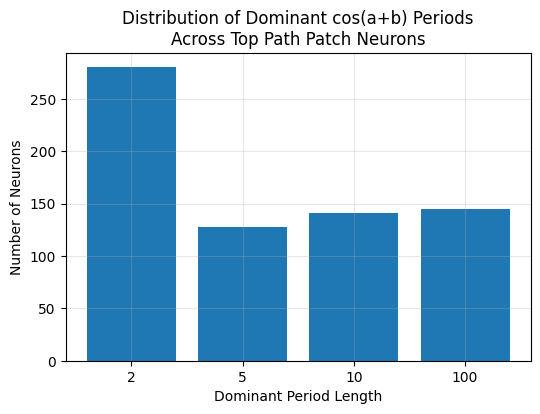

In [50]:
def plot_ab_term_hist():
    terms = load_ab_terms(frac = 1)
    periods = [2,5,10,100]
    # Get the most common period for each neuron
    dominant_periods = np.array(periods)[np.argmax(np.abs(terms), axis=1)]
    
    # Create bar plot
    plt.figure(figsize=(6,4))
    
    # Count occurrences of each period
    unique, counts = np.unique(dominant_periods, return_counts=True)
    period_counts = dict(zip(unique, counts))
    
    # Create bars at evenly spaced positions
    x_pos = np.arange(len(periods))
    heights = [period_counts.get(p, 0) for p in periods]
    
    plt.bar(x_pos, heights, align='center', width=0.8)
    
    plt.xlabel('Dominant Period Length')
    plt.ylabel('Number of Neurons')
    plt.title('Distribution of Dominant cos(a+b) Periods\nAcross Top Path Patch Neurons')
    
    # Set x-ticks to match the period values
    plt.xticks(x_pos, periods)
    
    plt.grid(True, alpha=0.3)
    
    plt.savefig('figs_addition/neuron_graphs/dominant_ab_periods_hist.png',
                bbox_inches='tight',
                dpi=300)
    plt.show()
    plt.close()

plot_ab_term_hist()

# Top Fourier Components in Logits 
For all Period 2 dominant component in neuron fit, what does the distribution of logit lens look like.

In [3]:
def read_logit_lens(idx):
    save_dir = "data_addition/neuron_logit_lens"
    for filename in os.listdir(save_dir):
        if filename.startswith(f"{idx}."):
            save_path = os.path.join(save_dir, filename)
            with open(save_path, 'rb') as f:
                data = pickle.load(f)
            break
    return data

def get_top_logits(idx):
    data = read_logit_lens(idx)
    logits = data['logits'][0]
    return logits

def get_top_fourier(idx):
    logits = get_top_logits(idx)
    fft_result = np.fft.fft(logits)
    magnitudes = np.abs(fft_result)
    dominant_freq_idx = np.argmax(magnitudes[1:]) + 1  # Skip DC component
    period = len(logits) / dominant_freq_idx
    return period.item()

def get_all_top_fouriers():
    ndf = get_ab_terms_ndf()#get_df()
    fouriers = []
    #bar = tqdm(range(len(ndf)))
    for idx in ndf['original_index']:
        fourier = get_top_fourier(idx)
        fouriers.append(fourier)
        #bar.set_postfix(layer=ndf.iloc[idx]['layer'], neuron_idx=ndf.iloc[idx]['neuron_idx'], abmag = abmag)
    ndf['top_fourier'] = fouriers
    ndf.to_pickle('data_addition/neuron_fits/neuron_ab_and_fourier.pkl')
    return ndf

def get_fouriers_top_fit_components(periods = [2,5,10,100]):
    ndf = pd.read_pickle('data_addition/neuron_fits/neuron_ab_and_fourier.pkl')
    ab_mags = ndf['ab_mags'].apply(lambda x: periods[np.argmax(np.abs(x))])
    return ab_mags.values, ndf['top_fourier'].values

#get_fouriers_top_fit_components()

In [2]:
def plot_top_fourier_dist():
    _, top_fourier = get_fouriers_top_fit_components()
    # Create bins in logspace from min to max of data
    plt.figure(figsize=(6,4))
    bins = np.logspace(np.log10(1), 
                      np.log10(top_fourier.max()), 
                      30)
    
    plt.hist(top_fourier, bins=bins)
    
    plt.xscale('log')
    plt.xticks([2, 5, 10, 25, 50, 66.3, 100, 200], 
               ['2', '5', '10', '25', '50', '66', '100', '200'], 
               rotation=45)
    
    plt.xlabel('Top Logits Fourier Period')
    plt.ylabel('Count')
    plt.title('Distribution of Logit Lens Fourier Periods')
    
    plt.tight_layout()
    plt.savefig('figs_addition/neuron_graphs/period_fourier_correlation/all_fourier.png')
    plt.show()

plot_top_fourier_dist()

NameError: name 'get_fouriers_top_fit_components' is not defined

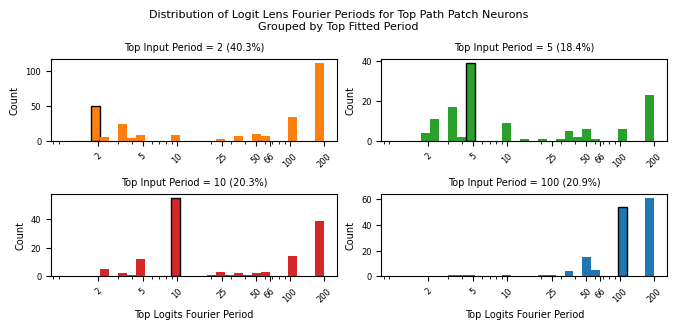

In [14]:
def plot_histogram_logit_fourier():
    top_period, top_fourier = get_fouriers_top_fit_components()
    
    fig, axs = plt.subplots(2, 2, figsize=(6.75, 3.25))
    fig.suptitle('Distribution of Logit Lens Fourier Periods for Top Path Patch Neurons\nGrouped by Top Fitted Period', fontsize = 8)
    axs = axs.ravel()
    
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#1f77b4'] # Orange, Green, Red, Blue
    periods = [2, 5, 10, 100]
    
    for i, (period, ax, color) in enumerate(zip(periods, axs, colors)):
        mask = top_period == period
        num_period, num_total = mask.sum(), len(mask)
        fourier_subset = top_fourier[mask]
        
        # Create bins in logspace from min to max of data
        bins = np.logspace(np.log10(1), 
                          np.log10(fourier_subset.max()), 
                          30)
        
        # Plot histogram with black edges for the bar at the input period
        n, bins, patches = ax.hist(fourier_subset, bins=bins, color=color)
        
        # Find and modify the bar containing the input period
        for j, (patch, left, right) in enumerate(zip(patches, bins[:-1], bins[1:])):
            if left <= period <= right:
                patch.set_edgecolor('black')
                patch.set_linewidth(1)
        
        ax.set_title(f'Top Input Period = {period} ({num_period/num_total*100:.1f}%)')
        if i >= 2:  # Only bottom plots
            ax.set_xlabel('Top Logits Fourier Period')
        ax.set_ylabel('Count')
        
        ax.set_xscale('log')
        ax.set_xticks([2, 5, 10, 25, 50, 66.3, 100, 200])
        ax.set_xticklabels(['2', '5', '10', '25', '50', '66', '100', '200'], rotation = 45)
    
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    os.makedirs('figs_addition/neuron_graphs/period_fourier_correlation', exist_ok=True)
    plt.savefig('figs_addition/neuron_graphs/period_fourier_correlation/neuron_logit_lens_fourier.png', bbox_inches = 'tight', dpi = 300)
    plt.show()

plot_histogram_logit_fourier()